In [1]:
import torch, os, math
from math import sqrt
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

from torchvision.datasets import MNIST
from torchvision import transforms
tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
train_dataset = MNIST("/media/volume/sdb/data", train=True, download=False, transform=tf)
val_dataset = MNIST("/media/volume/sdb/data", train=False, download=False, transform=tf)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=32, 
                                           shuffle=True, drop_last=True, 
                                           num_workers=1, 
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=32, 
                                         shuffle=False, 
                                         num_workers=1, 
                                         pin_memory=True)

# Set float32 matrix multiplication precision to medium
torch.set_float32_matmul_precision('medium')
print(len(val_dataset))
print(val_dataset[0][0].shape)
images, labels = zip(*[val_dataset[i] for i in range(32)])
images = np.array(images)
print(images.shape)

10000
torch.Size([1, 28, 28])
(32, 1, 28, 28)


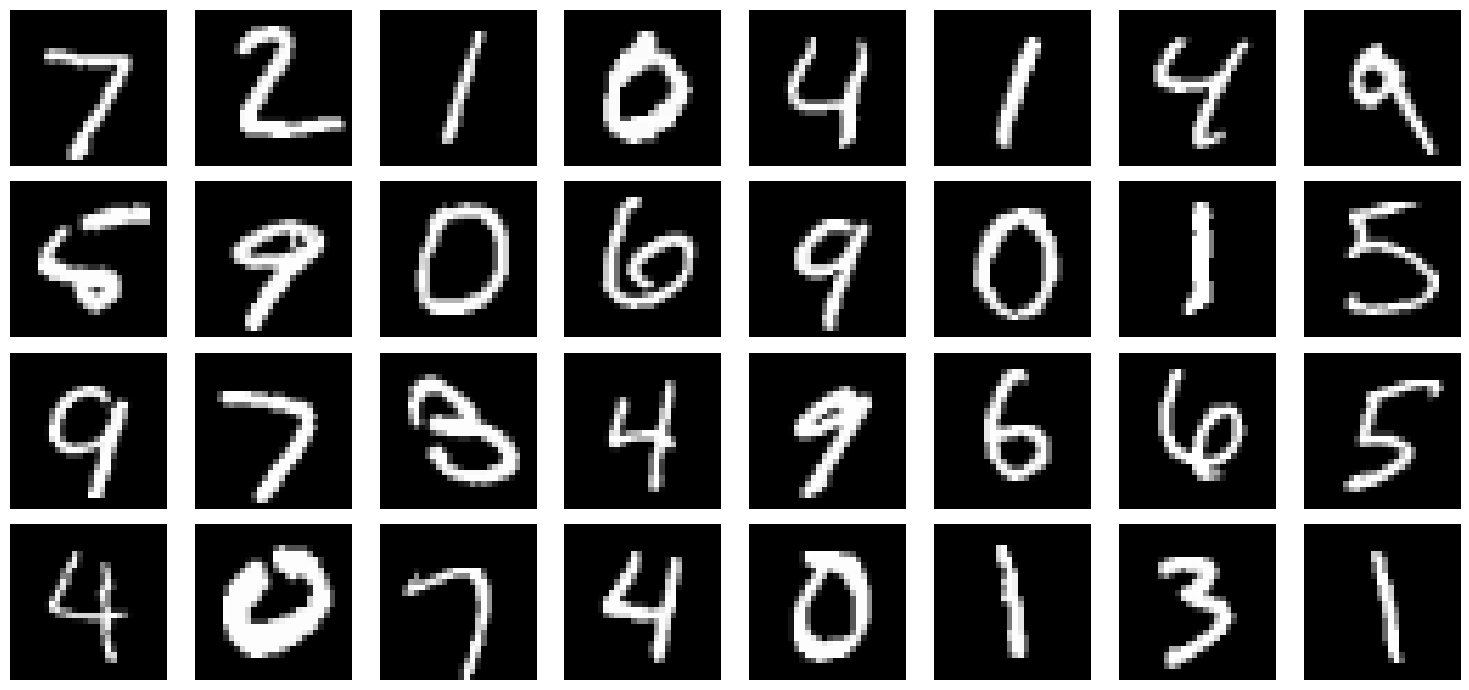

In [2]:
# Set up the plot
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(32):
    # Display image
    axes[i].imshow(images[i].squeeze(), cmap='gray')

    # Remove axis ticks
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Building a Variational Autoencoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        # Initial convolution block
        layers = [
                nn.Conv2d(1, dim, 4),
                nn.InstanceNorm2d(dim * 2),
                nn.Tanh(),
            ]

        # Downsampling
        for _ in range(4):
            layers += [
                nn.Conv2d(dim, dim * 2, 4),
                nn.InstanceNorm2d(dim * 2),
                nn.Tanh(),
            ]
            dim *= 2
        
        # Final block with 1D convolution for demonstration purposes
        layers += [
                nn.Conv2d(dim, 2, 1),  # THIS IS THE ONLY THING WE CHANGE IN THE NETWORK ARCH!! 
                                       # JUST OUTPUT 2X THE ORIGINAL LATENT SPACE FOR MEAN AND VAR
                nn.InstanceNorm2d(1),
                nn.Tanh(),
            ]

        self.model_blocks = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model_blocks(x)
        return x

class Decoder(nn.Module):
    def __init__(self, dim=32):
        super().__init__()
        dim = dim * 2 ** 3
        layers = [nn.Conv2d(1,dim,1),
                  nn.InstanceNorm2d(dim),
                  nn.LeakyReLU(0.2, inplace=True)
        ]


        # Upsampling
        for _ in range(5):
            layers += [
                nn.ConvTranspose2d(dim, dim // 2, 4),
                nn.InstanceNorm2d(dim // 2),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            dim = dim // 2

        # Output layer
        layers += [nn.Conv2d(dim, 1, 1)]

        self.model_blocks = nn.Sequential(*layers, nn.Sigmoid())

    def forward(self, x):
        x = self.model_blocks(x)
        return x

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        code = self.encoder(x)
        posterior = self.sample(code)
        reconstruction = self.decoder(posterior)
        return code, posterior, reconstruction
    
    def sample(self, latent):
        mu, logvar = torch.chunk(latent, 2, dim=1)
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        sampled_posterior = eps * std + mu #  N(0,I) ~ N(0,I) * std + mu
        return sampled_posterior
    
    def encode_and_sample_posterior(self, x):
        code = self.encoder(x)
        posterior = self.sample(code)
        return posterior

In [15]:
def vae_loss(recon, x, latent):
    mu, logvar = torch.chunk(latent, 2, dim=1)
    recon_loss = F.l1_loss(recon, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + (1 * kl_div)

def train_loop(data_loader, ae, opt, device):
    ae.train()
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        latent, _, recon = ae(images)
        loss = vae_loss(recon, images, latent)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def test_loop(data_loader, ae, device):
    ae.eval()
    running_loss = 0.
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        latent, _, recon = ae(images)
        loss = vae_loss(recon, images, latent)
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [16]:
# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Init all of our models
vae = VAE()
vae.to(device)
print("Number of parameters: ", sum(p.numel() for p in vae.parameters()))

opt = torch.optim.Adam(vae.parameters(), lr=3e-4)

for i in tqdm(range(1)):
    loss_rec = train_loop(train_loader, vae, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    loss_rec_test = test_loop(val_loader, vae, device)
    print('test loss: ', loss_rec_test)

Number of parameters:  3486947


  0%|          | 0/1 [00:00<?, ?it/s]

loss from epoch  0 :  282.8689130737305


100%|██████████| 1/1 [00:14<00:00, 14.80s/it]

test loss:  161.89316680713202


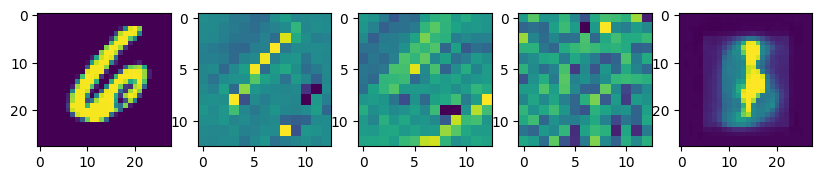

In [17]:
vae.eval()
image, label = train_dataset[737]
latent, sampled_posterior, pred = vae(image.to(device).unsqueeze(0))
# Init figure w/ subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(10, 5))

ax1.imshow(image.squeeze().numpy())
ax2.imshow(latent[0][0].detach().cpu().squeeze().numpy())
ax3.imshow(latent[0][-1].detach().cpu().squeeze().squeeze().numpy())
ax4.imshow(sampled_posterior.detach().cpu().squeeze().squeeze().numpy())
ax5.imshow(pred.detach().cpu().squeeze().squeeze().numpy())

In [18]:
sampled_posterior.shape

torch.Size([1, 1, 13, 13])

In [19]:
# find std of posteriors for dm training
stds = []
for i in range(100):
    with torch.no_grad():
        image, _ = train_dataset[i]
        image = image.to(device).unsqueeze(0)
        _, ps, _ = vae(image)
        stds.append(torch.std(ps).cpu())

p_stds = np.array(stds)
print(p_stds.shape)
p_std = p_stds.mean()
print('mean std of first 100 samples in train dataset is ', p_std)

(100,)
mean std of first 100 samples in train dataset is  1.0244995


# Build Latent Diffusion Model

In [20]:
# helper functions
def pad(var):
    if var.shape == ():
        return rearrange(var, ' -> 1 1 1 1')
    else:
        return rearrange(var, 'b -> b 1 1 1')
    
    
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.InstanceNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.InstanceNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        self.model = nn.Sequential(*[ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)])

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 3, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(6), nn.GELU())

        self.timeembed2 = nn.Sequential(nn.Conv2d(1,n_feat,1),nn.GELU())

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(n_feat, n_feat, 6, 6), # otherwise just have 2*n_feat
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
        )

        # self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up1 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t):
        # x is (noisy) image, t is timestep, 
        # print('t.shape', t.shape)
        temb = self.timeembed2(t)

        x = self.init_conv(x)
        down1 = self.down1(x)
        hiddenvec = self.to_vec(down1)

        up1 = self.up0(hiddenvec + t)  # add and multiply embeddings
        up3 = self.up1(up1 + temb, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

class DM(nn.Module):
    def __init__(self,
                device,
                number_of_timesteps=50,
                sigma_min = 0.002,     # min noise level
                sigma_max = 80,        # max noise level
                sigma_data = p_std,    # standard deviation of data distribution !!FOUND IN CELL ABOVE!!
                rho = 7,               # controls the sampling schedule
                P_mean = -1.2,         # mean of log-normal distribution from which noise is drawn for training
                P_std = 1.2,           # standard deviation of log-normal distribution from which noise is drawn for training
                S_churn = 80,          # parameters for stochastic sampling - depends on dataset, Table 5 in paper
                S_tmin = 0.05,
                S_tmax = 50.,
                S_noise = 1.003):
        super().__init__()
        self.network = ContextUnet(in_channels=1, n_feat=64)
        self.device = device
        
        # diffusion variables/constants
        self.n_T = number_of_timesteps
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.sigma_data = sigma_data

        self.rho = rho

        self.P_mean = P_mean
        self.P_std = P_std

        self.S_churn = S_churn
        self.S_tmin = S_tmin
        self.S_tmax = S_tmax
        self.S_noise = S_noise

    def forward(self, x, t):
        return self.network(x,t)
    
    def preconditioners(self, sigmas):
        c_in = 1 * (sigmas ** 2 + self.sigma_data ** 2) ** -0.5
        c_noise = log(sigmas) * 0.25
        c_skip = (self.sigma_data ** 2) / (sigmas ** 2 + self.sigma_data ** 2)
        c_out = sigmas * self.sigma_data * (self.sigma_data ** 2 + sigmas ** 2) ** -0.5
        return c_in, c_noise, c_skip, c_out
    
    def forward_with_preconditioners(self, x_t, sigmas):
        c_in, c_noise, c_skip, c_out = self.preconditioners(sigmas)
        network_latent, network_output = self.forward((c_in * x_t), c_noise)
        x_t_minus_1 = c_skip * x_t + c_out * network_output
        return network_latent, network_output, x_t_minus_1
    
    def noise_distribution(self, x_0):
        return (self.P_mean + self.P_std * torch.randn((x_0.shape[0],)).to(self.device)).exp()
    
    def forward_diffusion_process(self, x_0, sigmas):
        eps = torch.randn_like(x_0).to(self.device)
        x_t = x_0 + sigmas * eps
        return x_t
    
    def loss_weight(self, sigmas):
        return (sigmas ** 2 + self.sigma_data ** 2) * (sigmas * self.sigma_data) ** -2
    
    def loss(self, x_0):
        sigmas = pad(self.noise_distribution(x_0))
        x_t = self.forward_diffusion_process(x_0, sigmas)
                
        x_0_hat = self.forward(x_t, sigmas)
        
        reconstruction_loss = F.mse_loss(x_0_hat, x_0)
        loss = (self.loss_weight(sigmas) * reconstruction_loss).mean()
        return loss
    
    def sample_schedule(self):
        inv_rho = 1 / self.rho
        
        steps = torch.arange(self.n_T).to(self.device)
        sigmas = (self.sigma_max ** inv_rho + steps / (self.n_T - 1) * (self.sigma_min ** inv_rho - self.sigma_max ** inv_rho)) ** self.rho
        
        sigmas = F.pad(sigmas, (0,1), value = 0.)
        return sigmas
    
    @torch.no_grad()
    def reverse_diffusion_process(self, x_T):
        sigmas = self.sample_schedule()
        gammas = torch.where(
            (sigmas >= self.S_tmin) & (sigmas <= self.S_tmax),
            min(self.S_churn / self.n_T, sqrt(2) - 1),
            0.
        )
        sigmas_gammas = list(zip(sigmas[:-1], sigmas[1:], gammas[:-1]))
        
        sigma_T = sigmas[0]
        x_t = sigma_T * torch.randn_like(x_T).to(self.device)
        
        for sigma_t, sigma_tm1, gamma in tqdm(sigmas_gammas, desc = 'sampling time step'):
            x_t = self.reverse_diffusion_step(x_t, sigma_t, sigma_tm1, gamma)
    
        return x_t
    
    @torch.no_grad()
    def reverse_diffusion_step(self, x_t, sigma_t, sigma_tm1, gamma):
        eps = self.S_noise * torch.randn_like(x_t).to(self.device)
        
        sigma_t_hat = sigma_t + gamma * sigma_t
        x_t_hat = x_t + sqrt(sigma_t_hat ** 2 - sigma_t ** 2) * eps
        sigma_t_hat_ = sigma_t_hat.repeat(x_t.shape[0],1,1,1)
        
        output_t = self.forward(x_t_hat, sigma_t_hat_)
        denoised_over_sigma = (x_t_hat - output_t) / sigma_t_hat
        
        x_tm1 = x_t_hat + (sigma_tm1 - sigma_t_hat) * denoised_over_sigma
        
        # second order correction, unless final timestep
        if sigma_tm1 != 0:
            output_tm1 = self.forward(x_tm1, sigma_tm1.repeat(x_t.shape[0],1,1,1))
            denoised_prime_over_sigma = (x_tm1 - output_tm1) / sigma_tm1
            x_tm1 = x_t_hat + 0.5 * (sigma_tm1 - sigma_t_hat) * (denoised_over_sigma + denoised_prime_over_sigma)
            # switch to the following notation - so much cleaner!!!
            # x = x + d * dt
            # d = denoised_prime_over_sigma
        return x_tm1
        

In [21]:
def train_loop(data_loader, dm, vae, opt, device):
    vae.eval()
    dm.train()
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        # encode images with pretrained vae
        posterior = vae.encode_and_sample_posterior(images)
        # train dm with sampled posterior
        loss = dm.loss(posterior)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def test_loop(data_loader, dm, vae, device):
    vae.eval()
    dm.eval()
    running_loss = 0.
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        # encode images with pretrained vae
        posterior = vae.encode_and_sample_posterior(images)
        # train dm with sampled posterior
        loss = dm.loss(posterior)
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def generate_samples_with_ldm(dm, vae, device):
    vae.eval()
    dm.eval()
    with torch.no_grad():
        z_T = torch.randn((32, 1, 13, 13)).to(device)
        z_0 = dm.reverse_diffusion_process(z_T)
        x_0 = vae.decoder(z_0)
    return x_0
    
    

In [22]:
# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

dm = DM(device)
dm.to(device)

print("Number of parameters: ", sum(p.numel() for p in dm.parameters()))

opt_dm = torch.optim.Adam(dm.parameters(), lr=3e-4)

for i in tqdm(range(5)):
    loss_rec = train_loop(train_loader, dm, vae, opt_dm, device)
    print('loss from epoch ', i, ': ', loss_rec)
    loss_rec_test = test_loop(val_loader, dm, vae, device)
    print('test loss: ', loss_rec_test)

Number of parameters:  776641


  0%|          | 0/5 [00:00<?, ?it/s]

loss from epoch  0 :  50.872873734029135


 20%|██        | 1/5 [00:19<01:16, 19.03s/it]

test loss:  37.83181970645064
loss from epoch  1 :  45.52200783119201


 40%|████      | 2/5 [00:37<00:56, 18.88s/it]

test loss:  40.90777035186085
loss from epoch  2 :  45.33688837954203


 60%|██████    | 3/5 [00:56<00:37, 18.80s/it]

test loss:  48.26995969047181
loss from epoch  3 :  53.95263961537679


 80%|████████  | 4/5 [01:15<00:18, 18.78s/it]

test loss:  52.0954884964818
loss from epoch  4 :  38.39329614384969


100%|██████████| 5/5 [01:33<00:00, 18.80s/it]

test loss:  37.17490546619549


sampling time step: 100%|██████████| 50/50 [00:00<00:00, 256.16it/s]


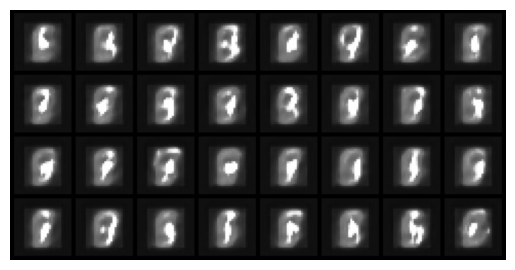

In [23]:
x_0 = generate_samples_with_ldm(dm, vae, device)
grid = make_grid(x_0.cpu(), nrow=8, padding=2)

plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()